# Weather compensation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('simulation_results_finished.csv')
outdoor_temp_series = df['Dry-bulb temperature (°C)']

In [3]:
# Heat demand calculation function
def calculate_heat_loss_space(K, indoor_temp, outdoor_temp): 
    return K * (indoor_temp - outdoor_temp)

# Flow temperature calculation function
def calculate_target_flow_temp(lower_temp, upper_temp, lower_flow, upper_flow, outdoor_temp):
    """Heating Curve Calculation

    Args:
        lower_temp (float): lower outdoor temperature
        upper_temp (float): upper outdoor temperature
        lower_flow (float): lower flow temperature
        upper_flow (float): upper flow temperature
        outdoor_temp (float): outdoor temperature
    """
    if outdoor_temp < lower_temp:
        return upper_flow
    elif outdoor_temp > upper_temp:
        return lower_flow
    else:
        return lower_flow + ((upper_flow - lower_flow) / (upper_temp - lower_temp)) * (upper_temp - outdoor_temp)

In [4]:
# Constants for the building and heating system
TARGET_INDOOR_TEMP = 19.0  # Target indoor temperature (°C)

# Heat loss coefficient
K_SH = 220 # Heat loss coefficient for space heating (kW/°C)

# Heat pump operation outdoor temp threshold
# HP_operation_threshold = 15.0

# Heat pump operation threshold (hysteresis control to prevent rapid cycling)
operation_margin = 1.0  # Margin in degrees for switching heat pump on/off

# Define heating curve parameters
lower_outdoor_temp = -20  # Lower outdoor temperature for heating curve (°C)
upper_outdoor_temp = 20  # Upper outdoor temperature for heating curve (°C)
lower_flow_temp = 20     # Lower flow temperature for heating curve (°C)
upper_flow_temp = 50     # Upper flow temperature for heating curve (°C)  

# Building heat demand calculation parameters
c_water = 4186.0            # Specific heat capacity of water in J/kg.K
rho_water = 1000.0          # Density of water in kg/m^3
flow_rate = 0.2            # Flow rate in kg/s (assumed constant for simplicity)

# Internal gains
internal_gains = 600  # Internal heat gains in W

# Building conditions
rho_in = 1.2041  # Air density in kg/m^3
c_in = 1000      # Specific heat capacity of air in J/(kg*K)
V_in = 3277      # Volume of the building in m^3

# Time step in hours
delta_t = 0.5

# Initialize lists to store results
heat_power_profile = []
heat_demand_profile = []
target_flow_temps = []
# heat_pump_status = []
flow_temp = 45  # Initialize current flow temperature
flow_temps = []
return_temps = []
COPs = []
elec_power_profile = []


# Simulate each hour in the time period
for outdoor_temp in outdoor_temp_series:
    
    if outdoor_temp >= TARGET_INDOOR_TEMP:
        # heat_pump_status.append("Off")
        heat_power = 0
        target_flow_temp = outdoor_temp
        flow_temp = target_flow_temp
        return_temp = flow_temp
        flow_temps.append(flow_temp)
        return_temps.append(return_temp)
        target_flow_temps.append(target_flow_temp)
        electric_power = 0
        elec_power_profile.append(electric_power)
        Practical_COP = 0
        COPs.append(Practical_COP)
        
        
    else:
        # heat_pump_status.append("On")
        # Calculate the target flow temperature based on heat demand and outdoor temperature
        target_flow_temp = calculate_target_flow_temp(lower_temp=lower_outdoor_temp, 
                                                        upper_temp=upper_outdoor_temp, 
                                                        lower_flow=lower_flow_temp, 
                                                        upper_flow=upper_flow_temp, 
                                                        outdoor_temp=outdoor_temp)
        target_flow_temps.append(target_flow_temp)  
        
        flow_temp = target_flow_temp
        flow_temps.append(flow_temp)
        
        # Internal gains + heat power = heat loss
        # heat_power = c_water * flow_rate * (flow_temp - return_temp)
        # heat_loss = K_SH * (indoor_temp - outdoor_temp)
        
        # Calculate heat loss (W)
        heat_loss = calculate_heat_loss_space(K_SH, TARGET_INDOOR_TEMP, outdoor_temp)
        
        # Calculate heat power (W)
        heat_power = max(0, heat_loss - internal_gains)
        
        return_temp = flow_temp - ((heat_loss - internal_gains) / (flow_rate * c_water))
        return_temps.append(return_temp)
        
        # Calculate COP
        T_condensing = flow_temp + 2
        T_evaporating = outdoor_temp - 6 
        
        Carnot_COP = (T_condensing + 273) / ((T_condensing+273) - (T_evaporating + 273))
        Practical_COP = 0.5 * Carnot_COP
        COPs.append(Practical_COP)
        
        elec_power = heat_power / Practical_COP
        elec_power_profile.append(elec_power/1000)
        
        
    heat_power_profile.append(heat_power/1000) # Convert to kW
    heat_demand_profile.append((heat_power/1000) * 0.5) # Convert to kWh


In [5]:
# Create a DataFrame to store the results
simulation_data = pd.DataFrame({
    "Date": df["Date"],
    "Outdoor Temperature (°C)": outdoor_temp_series,
    "Heat Power (kW)": heat_power_profile,
    "Heat Demand (kWh)": heat_demand_profile,
    "Electric Power (kW)": elec_power_profile,
    "COP": COPs,
    "Target Flow Temperature (°C)": target_flow_temps,
    "Flow Temperature (°C)": flow_temps,
    "Return Temperature (°C)": return_temps
})

In [6]:
# Save the results to a CSV file
simulation_data.to_csv("simulation_results_weather_compensation.csv", index=False)

In [7]:
np.sum(simulation_data['Heat Demand (kWh)'])

np.float64(15910.225999999999)

# Visualisation

In [8]:
simulation_data['Date'] = pd.to_datetime(simulation_data['Date'], format='%Y-%m-%d %H:%M:%S')
simulation_data.set_index('Date', inplace=True)

In [9]:
simulation_data.head()

,Outdoor Temperature (°C),Heat Power (kW),Heat Demand (kWh),Electric Power (kW),COP,Target Flow Temperature (°C),Flow Temperature (°C),Return Temperature (°C)
Date,,,,,,,,
2023-01-01 00:00:00,5.5,2.37,1.185,0.517197,4.582397,30.875,30.875,28.044135
2023-01-01 00:30:00,5.5,2.37,1.185,0.517197,4.582397,30.875,30.875,28.044135
2023-01-01 01:00:00,5.5,2.37,1.185,0.517197,4.582397,30.875,30.875,28.044135
2023-01-01 01:30:00,5.5,2.37,1.185,0.517197,4.582397,30.875,30.875,28.044135
2023-01-01 02:00:00,5.5,2.37,1.185,0.517197,4.582397,30.875,30.875,28.044135


## Annual half hourly profile

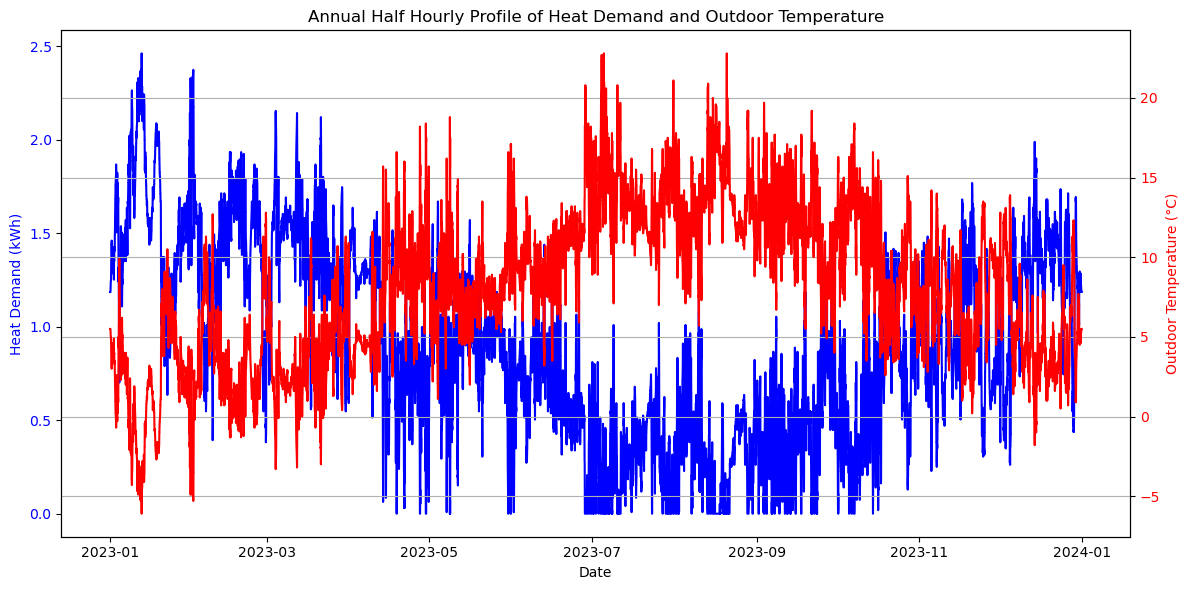

In [10]:
# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Heat Demand on the first y-axis
ax1.plot(simulation_data.index, simulation_data['Heat Demand (kWh)'], label='Half Hourly Heat Demand', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Heat Demand (kWh)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis
ax2 = ax1.twinx()
ax2.plot(simulation_data.index, simulation_data['Outdoor Temperature (°C)'], label='Half Hourly Temperature', color='red')
ax2.set_ylabel('Outdoor Temperature (°C)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Title and grid
plt.title('Annual Half Hourly Profile of Heat Demand and Outdoor Temperature')
fig.tight_layout()
plt.grid()
plt.savefig('./figures/annual_half_hourly_profile_weather_compensation.pdf')
plt.show()

## Annual hourly profile

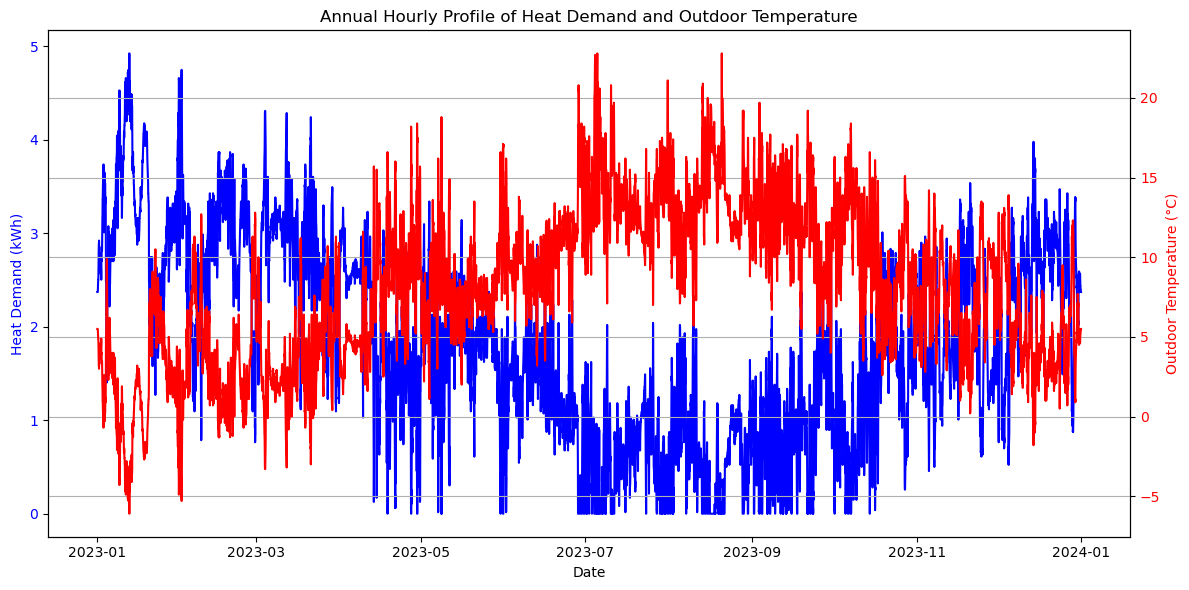

In [11]:
# Resample to hourly frequency and calculate the sum of heat demand and average outdoor temperature
hourly_df = simulation_data["Heat Demand (kWh)"].resample('h').sum().to_frame()
hourly_df['Outdoor Temperature (°C)'] = simulation_data["Outdoor Temperature (°C)"].resample('h').mean()

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Heat Demand on the first y-axis
ax1.plot(hourly_df.index, hourly_df['Heat Demand (kWh)'], label='Hourly Heat Demand', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Heat Demand (kWh)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis
ax2 = ax1.twinx()
ax2.plot(hourly_df.index, hourly_df['Outdoor Temperature (°C)'], label='Hourly Temperature', color='red')
ax2.set_ylabel('Outdoor Temperature (°C)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Title and grid
plt.title('Annual Hourly Profile of Heat Demand and Outdoor Temperature')
fig.tight_layout()
plt.grid()
plt.savefig('./figures/annual_hourly_profile_weather_compensation.pdf')
plt.show()

In [12]:
print(f"The average hourly heat demand: {np.mean(hourly_df['Heat Demand (kWh)'])} kWh\n\
The maximum hourly heat demand: {np.max(hourly_df['Heat Demand (kWh)'])} kWh\n\
The minimum hourly heat demand: {np.min(hourly_df['Heat Demand (kWh)'])} kWh")

The average hourly heat demand: 1.8162358447488587 kWh
The maximum hourly heat demand: 4.922 kWh
The minimum hourly heat demand: 0.0 kWh


## Daily hourly profile

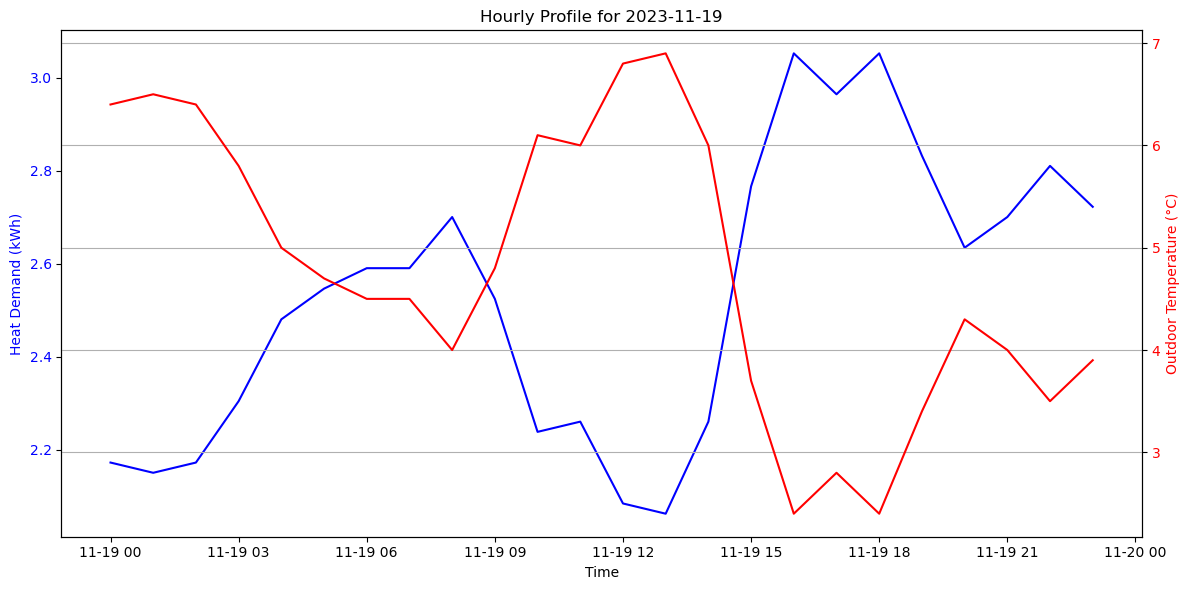

In [13]:
# Specify the day you want to plot
specific_day = '2023-11-19'  # Change this to the desired date

# Filter the data for the specific day
daily_profile = hourly_df.loc[specific_day]

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Heat Demand on the first y-axis
ax1.plot(daily_profile.index, daily_profile['Heat Demand (kWh)'], label='Hourly Heat Demand', color='blue')
ax1.set_xlabel('Time')
ax1.set_ylabel('Heat Demand (kWh)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis
ax2 = ax1.twinx()
ax2.plot(daily_profile.index, daily_profile['Outdoor Temperature (°C)'], label='Hourly Temperature', color='red')
ax2.set_ylabel('Outdoor Temperature (°C)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Title and grid
plt.title(f'Hourly Profile for {specific_day}')
fig.tight_layout()
plt.grid()
plt.savefig(f'./figures/hourly_profile_{specific_day}_weather_compensation.pdf')
plt.show()

## Annual daily profile

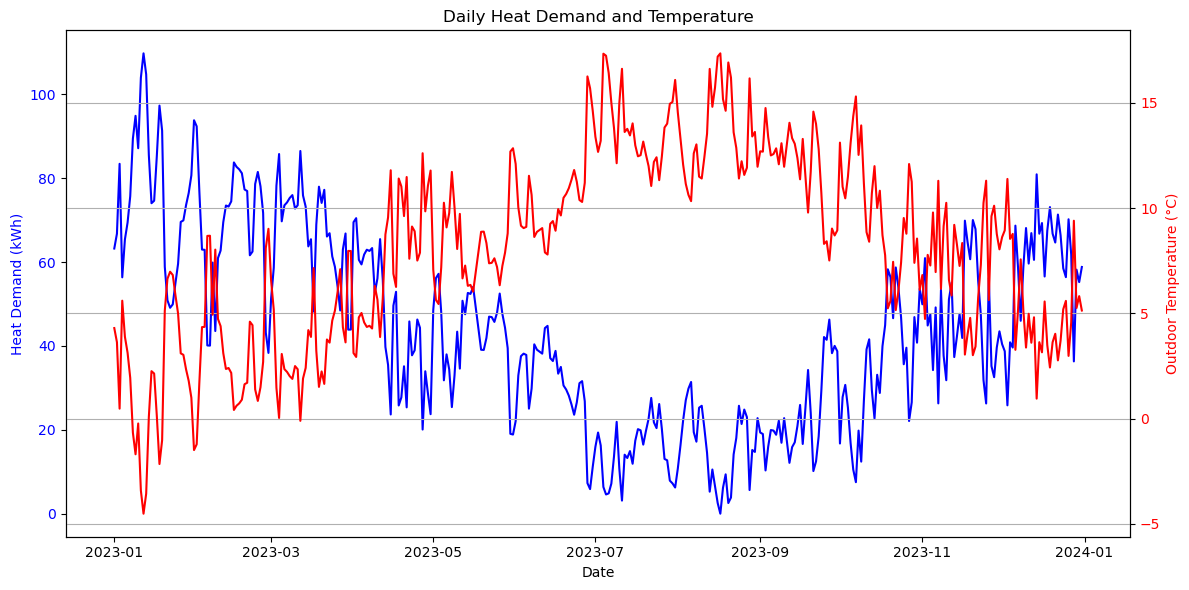

In [14]:
# Resample to daily frequency and calculate the sum of heat demand and average outdoor temperature
daily_df = simulation_data["Heat Demand (kWh)"].resample('D').sum().to_frame()
daily_df['Outdoor Temperature (°C)'] = simulation_data["Outdoor Temperature (°C)"].resample('D').mean()

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Heat Demand on the first y-axis
ax1.plot(daily_df.index, daily_df['Heat Demand (kWh)'], label='Daily Heat Demand', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Heat Demand (kWh)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis
ax2 = ax1.twinx()
ax2.plot(daily_df.index, daily_df['Outdoor Temperature (°C)'], label='Daily Temperature', color='red')
ax2.set_ylabel('Outdoor Temperature (°C)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Title and grid
plt.title('Daily Heat Demand and Temperature')
fig.tight_layout()
plt.grid()
plt.savefig('./figures/annual_daily_profile_weather_compensation.pdf')
plt.show()

In [15]:
print(f"The average daily heat demand: {np.mean(daily_df['Heat Demand (kWh)'])} kWh\n\
The maximum daily heat demand: {np.max(daily_df['Heat Demand (kWh)'])} kWh\n\
The minimum daily heat demand: {np.min(daily_df['Heat Demand (kWh)'])} kWh")

The average daily heat demand: 43.5896602739726 kWh
The maximum daily heat demand: 109.746 kWh
The minimum daily heat demand: 0.0 kWh


## Monthly daily profile

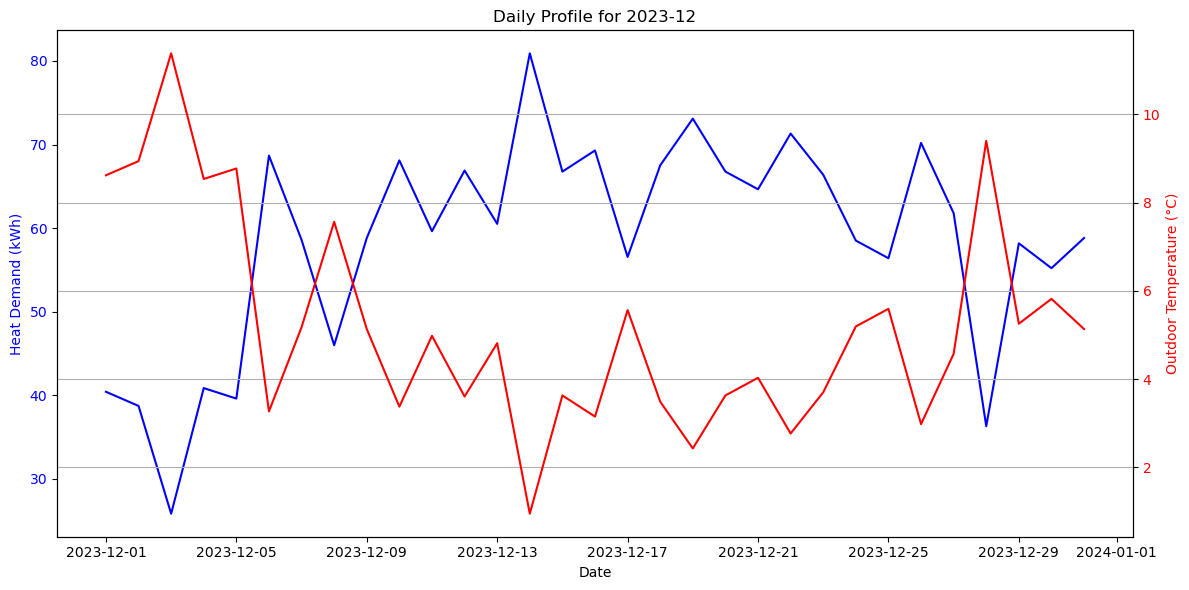

In [16]:
# Specify the month you want to plot
specific_month = '2023-12'  # Change this to the desired month

# Filter the data for the specific month
monthly_profile = daily_df.loc[specific_month]

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Heat Demand on the first y-axis
ax1.plot(monthly_profile.index, monthly_profile['Heat Demand (kWh)'], label='Daily Heat Demand', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Heat Demand (kWh)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis
ax2 = ax1.twinx()
ax2.plot(monthly_profile.index, monthly_profile['Outdoor Temperature (°C)'], label='Daily Temperature', color='red')
ax2.set_ylabel('Outdoor Temperature (°C)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Title and grid
plt.title(f'Daily Profile for {specific_month}')
fig.tight_layout()
plt.grid()
plt.savefig(f'./figures/monthly_profile_{specific_month}_weather_compensation.pdf')
plt.show()

## Annual monthly profile

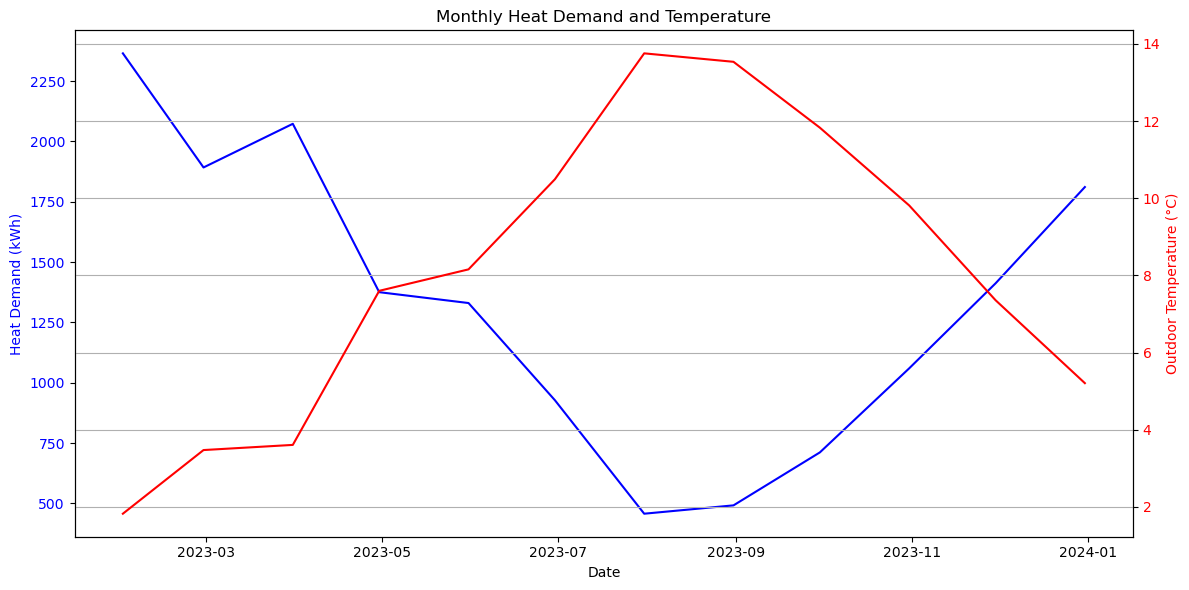

In [17]:
# Resample to daily frequency and calculate the sum of heat demand and average outdoor temperature
monthly_df = simulation_data["Heat Demand (kWh)"].resample('ME').sum().to_frame()
monthly_df['Outdoor Temperature (°C)'] = simulation_data["Outdoor Temperature (°C)"].resample('ME').mean()

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Heat Demand on the first y-axis
ax1.plot(monthly_df.index, monthly_df['Heat Demand (kWh)'], label='Monthly Heat Demand', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Heat Demand (kWh)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis
ax2 = ax1.twinx()
ax2.plot(monthly_df.index, monthly_df['Outdoor Temperature (°C)'], label='Monthly Temperature', color='red')
ax2.set_ylabel('Outdoor Temperature (°C)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Title and grid
plt.title('Monthly Heat Demand and Temperature')
fig.tight_layout()
plt.grid()
plt.savefig('./figures/annual_monthly_profile_weather_compensation.pdf')
plt.show()

In [18]:
print(f"The average monthly heat demand: {np.mean(monthly_df['Heat Demand (kWh)'])} kWh\n\
The maximum monthly heat demand: {np.max(monthly_df['Heat Demand (kWh)'])} kWh\n\
The minimum monthly heat demand: {np.min(monthly_df['Heat Demand (kWh)'])} kWh")

The average monthly heat demand: 1325.8521666666668 kWh
The maximum monthly heat demand: 2365.178 kWh
The minimum monthly heat demand: 457.698 kWh
